### Agenda:
1. Data Loading & Preprocessing
   - Missing values handling
   - Date features creation
   - Train/Test split
   - Scaling
   - Sequences
   - Data Loader (incl. indexing for Basisformer)
2. Experimental Design
    - Benchmark Models
      - Linear Regression
      - LSTM
    - Pre trained Chronos
    - Transformers
      - Unification
      - Non-Stationary Autoformer
      - BasisFormer
      - iTransformer
3. Results
4. Outlook
   - Chronos Simulation Framework
   - DYNOTEARS Causal Structure
   - Non linear causal structure
   - Data Augmentation

In [1]:
#!pip install torch==2.0.1

# 1. Data Loading & Preprocessing

In [2]:
import torch

In [3]:
import pandas as pd
import numpy as np

In [4]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.utils.weight_norm as wn
import torch.nn.functional as F

In [5]:
from sklearn.preprocessing import StandardScaler
import argparse
import os
import logging
import time
import importlib

In [6]:
#from torch.utils.tensorboard import SummaryWriter

In [7]:
##file_path = '/content/all_countries.csv' ## colab path
file_path = 'data/all_countries.csv' ## jupyter path
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Austria,AUT,2015-01-01 00:00:00,2015-01-01 01:00:00,17.93
1,Austria,AUT,2015-01-01 01:00:00,2015-01-01 02:00:00,15.17
2,Austria,AUT,2015-01-01 02:00:00,2015-01-01 03:00:00,16.38
3,Austria,AUT,2015-01-01 03:00:00,2015-01-01 04:00:00,17.38
4,Austria,AUT,2015-01-01 04:00:00,2015-01-01 05:00:00,16.38


In [8]:
df = df [['Country','Datetime (UTC)',  'Price (EUR/MWhe)']]
df = df.pivot(index='Datetime (UTC)', columns='Country', values='Price (EUR/MWhe)')
df.head()

Country,Austria,Belgium,Bulgaria,Croatia,Czechia,Denmark,Estonia,Finland,France,Germany,...,Norway,Poland,Portugal,Romania,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland
Datetime (UTC),,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,17.93,34.94,NaN,NaN,24.20,18.29,23.37,23.37,34.94,17.93,...,27.36,17.18,48.10,44.17,NaN,24.20,23.25,48.10,23.37,43.43
2015-01-01 01:00:00,15.17,32.19,NaN,NaN,22.06,16.04,19.33,19.33,32.19,15.17,...,27.24,17.38,47.33,39.17,NaN,22.06,22.20,47.33,19.33,38.08
2015-01-01 02:00:00,16.38,28.05,NaN,NaN,20.27,14.60,17.66,17.66,23.53,16.38,...,27.16,17.40,42.27,26.93,NaN,20.27,19.56,42.27,17.66,35.47
2015-01-01 03:00:00,17.38,28.04,NaN,NaN,19.17,14.95,17.53,17.53,22.92,17.38,...,27.15,18.60,38.41,20.94,NaN,19.17,18.88,38.41,17.53,30.83
2015-01-01 04:00:00,16.38,34.26,NaN,NaN,17.90,14.50,18.07,18.07,34.26,16.38,...,27.30,19.30,35.72,18.52,NaN,17.90,18.39,35.72,18.07,28.26


In [9]:
print(df.isnull().sum())

Country
Austria                0
Belgium                0
Bulgaria           15336
Croatia            24096
Czechia                0
Denmark                0
Estonia                0
Finland                0
France                 0
Germany                0
Greece                 0
Hungary                0
Ireland            12480
Italy                  0
Latvia                 0
Lithuania              0
Luxembourg             0
Netherlands            0
North Macedonia    73008
Norway                 0
Poland                 0
Portugal               0
Romania                0
Serbia             16800
Slovakia               0
Slovenia               0
Spain                  0
Sweden                 0
Switzerland            0
dtype: int64


In [10]:
df = df.dropna(axis=1)
print(df.isnull().sum())

Country
Austria        0
Belgium        0
Czechia        0
Denmark        0
Estonia        0
Finland        0
France         0
Germany        0
Greece         0
Hungary        0
Italy          0
Latvia         0
Lithuania      0
Luxembourg     0
Netherlands    0
Norway         0
Poland         0
Portugal       0
Romania        0
Slovakia       0
Slovenia       0
Spain          0
Sweden         0
Switzerland    0
dtype: int64


In [11]:
df.reset_index(inplace=True)
df.columns.name = None
print(df.head())

        Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  Finland  \
0  2015-01-01 00:00:00    17.93    34.94    24.20    18.29    23.37    23.37   
1  2015-01-01 01:00:00    15.17    32.19    22.06    16.04    19.33    19.33   
2  2015-01-01 02:00:00    16.38    28.05    20.27    14.60    17.66    17.66   
3  2015-01-01 03:00:00    17.38    28.04    19.17    14.95    17.53    17.53   
4  2015-01-01 04:00:00    16.38    34.26    17.90    14.50    18.07    18.07   

   France  Germany  Greece  ...  Netherlands  Norway  Poland  Portugal  \
0   34.94    17.93   48.78  ...        34.94   27.36   17.18     48.10   
1   32.19    15.17   31.10  ...        32.19   27.24   17.38     47.33   
2   23.53    16.38   20.78  ...        28.05   27.16   17.40     42.27   
3   22.92    17.38   25.40  ...        28.04   27.15   18.60     38.41   
4   34.26    16.38   26.00  ...        34.26   27.30   19.30     35.72   

   Romania  Slovakia  Slovenia  Spain  Sweden  Switzerland  
0    44.17   

In [12]:
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])
last_time_point = df['Datetime (UTC)'].max()
print("Last time point available:", last_time_point)

Last time point available: 2024-03-31 23:00:00


In [13]:
start_date = '2024-02-01 01:00:00' ## FILTERING ONLY FOR 3 MONTHS
df = df[df['Datetime (UTC)'] >= pd.to_datetime(start_date)]
print(df)

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
79633 2024-02-01 01:00:00    66.59    44.47    80.01    30.49    26.71   
79634 2024-02-01 02:00:00    64.13    45.15    80.01    31.12    38.22   
79635 2024-02-01 03:00:00    69.80    49.02    80.01    31.95    27.71   
79636 2024-02-01 04:00:00    80.78    57.56    87.10    35.01    20.10   
79637 2024-02-01 05:00:00    86.95    70.56    95.00    39.04    72.59   
...                   ...      ...      ...      ...      ...      ...   
81067 2024-03-31 19:00:00    66.17    47.01    68.37    70.00    50.09   
81068 2024-03-31 20:00:00    61.25    43.70    63.26    64.51    46.28   
81069 2024-03-31 21:00:00    44.99    50.29    51.29    54.90    43.98   
81070 2024-03-31 22:00:00    40.70    50.32    46.39    49.95    40.41   
81071 2024-03-31 23:00:00    32.10    44.39    42.60    48.98    40.39   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
79633    -2.49   46.66    42.16   

In [14]:
df['month'] = df['Datetime (UTC)'].apply(lambda row: row.month)
df['day'] = df['Datetime (UTC)'].apply(lambda row: row.day)
df['weekday'] = df['Datetime (UTC)'].apply(lambda row: row.weekday())
df['hour'] = df['Datetime (UTC)'].apply(lambda row: row.hour)

print(df.head())

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
79633 2024-02-01 01:00:00    66.59    44.47    80.01    30.49    26.71   
79634 2024-02-01 02:00:00    64.13    45.15    80.01    31.12    38.22   
79635 2024-02-01 03:00:00    69.80    49.02    80.01    31.95    27.71   
79636 2024-02-01 04:00:00    80.78    57.56    87.10    35.01    20.10   
79637 2024-02-01 05:00:00    86.95    70.56    95.00    39.04    72.59   

       Finland  France  Germany  Greece  ...  Romania  Slovakia  Slovenia  \
79633    -2.49   46.66    42.16   80.00  ...    80.00     91.00     71.73   
79634    -2.50   47.04    43.05   73.06  ...    73.06     80.19     67.66   
79635    -2.07   51.06    46.91   83.80  ...    83.80     96.02     75.10   
79636    -1.84   59.82    55.34   99.57  ...    99.57    116.13     87.74   
79637    -0.10   72.42    69.01  107.36  ...   107.36    108.87     95.63   

       Spain  Sweden  Switzerland  month  day  weekday  hour  
79633  55.10   -2.49        7

In [15]:
# separating the electricity prices and timestamp features
electricity_prices_df = df[['Datetime (UTC)', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
              'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
             'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia',
             'Slovenia', 'Spain', 'Sweden', 'Switzerland']]
timestamp_features_df = df[['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']]

# defining the split ratio
train_size = 0.8
train_size_electricity = int(len(electricity_prices_df) * train_size)
train_size_timestamp = int(len(timestamp_features_df) * train_size)

# spliting the data into train and test sets
electricity_prices_train = electricity_prices_df[:train_size_electricity]
electricity_prices_test = electricity_prices_df[train_size_electricity:]
timestamp_features_train = timestamp_features_df[:train_size_timestamp]
timestamp_features_test = timestamp_features_df[train_size_timestamp:]

In [16]:
#print(electricity_prices_train.head())

In [17]:
#country_names = electricity_prices_train.drop(columns=['Datetime (UTC)']).columns.tolist()

In [18]:
# rescaling the electricity prices
scaler = StandardScaler()

electricity_prices_train_scaled = scaler.fit_transform(electricity_prices_train.drop(columns=['Datetime (UTC)']))
electricity_prices_test_scaled = scaler.transform(electricity_prices_test.drop(columns=['Datetime (UTC)']))

In [19]:
#electricity_prices_train_scaled

In [20]:
def create_sequences(data, seq_length, pred_length, label_length, curr_model):
    seq_x = [] # storing for input seqiences
    seq_y = [] # storing for output seqiences
    for i in range(len(data) - seq_length - pred_length):
        seq_x.append(data[i:i+seq_length])
        if curr_model in ["basis_former", "itransformer", "ns_autoformer"]:
          seq_y.append(data[i+seq_length-label_length:i+seq_length+pred_length])
        else: ## only chronos
          seq_y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(seq_x), np.array(seq_y)

In [21]:
def create_dataloader(seq_x, seq_y, seq_x_mark, seq_y_mark, batch_size, curr_model):
    seq_x = torch.tensor(seq_x, dtype=torch.float32)
    seq_y = torch.tensor(seq_y, dtype=torch.float32)
    seq_x_mark = torch.tensor(seq_x_mark, dtype=torch.float32)
    seq_y_mark = torch.tensor(seq_y_mark, dtype=torch.float32)
    
    if curr_model == "basis_former":
        indices = []
        total_len = len(seq_x)
        for i in range(total_len):
            index_list = np.arange(i, i + len(seq_x[0]) + len(seq_y[0]), 1)
            norm_index = index_list / total_len
            indices.append(norm_index)
        indices = torch.tensor(indices, dtype=torch.float32)
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark, indices)
    else:
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
    return dataloader

# 2. Experimental Design

In [22]:
seq_length = 96
pred_length = 48
label_length = 48
batch_size = 24
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")

# Benchmark Models

## Linear Regression

### Linear Model Preprocessing

In [23]:
# Copy the main dataframe for linear model preprocessing
df_linear = df.copy()

# Define the number of lagged features
lag_steps = 3

# List of all columns (already defined in the main preprocessing)
all_columns = df_linear.columns.tolist()

# List of columns to exclude (non-country columns)
exclude_columns = ['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']

# Define the country columns by excluding non-country columns
countries = [col for col in all_columns if col not in exclude_columns]

# Create lagged features for each country
for country in countries:
    for lag in range(1, lag_steps + 1):
        df_linear[f'{country}_lag_{lag}'] = df_linear[country].shift(lag)

# Drop rows with NaN values due to lagging
df_linear.dropna(inplace=True)

# Define features (X) and targets (Y)
X_numerical = df_linear.drop(columns=countries + ['Datetime (UTC)'])
Y = df_linear[countries]  # Target: current prices of all countries

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Split data into training and testing sets
train_size = 0.8
train_size_idx = int(len(X_scaled) * train_size)
X_train, X_test = X_scaled[:train_size_idx], X_scaled[train_size_idx:]
Y_train, Y_test = Y[:train_size_idx], Y[train_size_idx:]

### Linear Regression Model

In [24]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_lr = model_lr.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(Y_test, Y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")

Linear Regression Mean Squared Error: 175.27310416307077


## LSTM

### LSTM Preprocessing

In [25]:
from sklearn.preprocessing import StandardScaler

# Copy the main dataframe for LSTM model preprocessing
df_lstm = df.copy()

# Rescale the data using StandardScaler for LSTM
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_lstm.drop(columns=['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']))

# Convert to a supervised learning problem by creating sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps)
seq_length = 24

# Create sequences
X, y = create_sequences(data_scaled, seq_length)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### LSTM Model

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, X.shape[2])))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=y.shape[1]))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model_lstm.fit(X_train, y_train, epochs=1, batch_size=24, validation_data=(X_test, y_test))

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)

# Inverse transform the scaled data to original values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred_lstm)

# Evaluate the model
mse_lstm = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"LSTM Mean Squared Error: {mse_lstm}")

### Improved LSTM MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define an improved LSTM model
model_lstm = Sequential()

# Increase the number of units in LSTM layers
model_lstm.add(LSTM(units=64, return_sequences=True, input_shape=(seq_length, X.shape[2])))
model_lstm.add(Dropout(0.2))  # Add dropout for regularization

model_lstm.add(LSTM(units=64, return_sequences=False))
model_lstm.add(Dropout(0.2))  # Add dropout for regularization

# Output layer
model_lstm.add(Dense(units=y.shape[1]))

# Compile the model with a slightly lower learning rate
model_lstm.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Early stopping to prevent overfitting and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Fit the model
model_lstm.fit(X_train, y_train, epochs=1, batch_size=24, 
               validation_data=(X_test, y_test), 
               callbacks=[early_stopping, reduce_lr])

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)

# Inverse transform the scaled data to original values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred_lstm)

# Evaluate the model
mse_lstm = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"Improved LSTM Mean Squared Error: {mse_lstm}")

# Pre trained model Chronos

zero shot evaluation with Chronos Pretrained Model

In [ ]:
#!pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [ ]:
import chronos
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt

# Assuming df is your initial dataset
# Make sure 'Datetime (UTC)' is set as the index
#df = df.set_index('Datetime (UTC)')

# Select the countries we want to forecast
selected_countries = ['Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
              'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
             'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia',
             'Slovenia', 'Spain', 'Sweden', 'Switzerland']

# Extract the data for selected countries
data = df[selected_countries]

# Print some basic information about the dataset
#print(f"Dataset shape: {data.shape}")
#print(f"Date range: from {data.index.min()} to {data.index.max()}")
#print(f"Any missing values: {data.isnull().any().any()}")

# Define the split point for train and test
split_point = int(len(data) * 0.8)  # 80% for training, 20% for testing

# Split the data
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]

#print(f"\nTrain data shape: {train_data.shape}")
#print(f"Test data shape: {test_data.shape}")

# Function to prepare data for Chronos
def prepare_chronos_data(data, seq_length):
    return torch.tensor(data[-seq_length:].values, dtype=torch.float32).unsqueeze(0)

# Initialize Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Set parameters
seq_length = 96
pred_length = 48

#print(f"\nSequence length: {seq_length} (equivalent to {seq_length/24} days)")
#print(f"Prediction length: {pred_length} (equivalent to {pred_length/24} days)")

# Prepare data and run forecasts
results = {}

for country in selected_countries:
    print(f"\nProcessing {country}")
    print(f"Data range for {country}: {train_data[country].min()} to {train_data[country].max()}")
    
    # Prepare input for Chronos
    chronos_input = prepare_chronos_data(train_data[country], seq_length)
    print(f"Chronos input shape: {chronos_input.shape}")
    
    # Generate forecast
    forecast = pipeline.predict(
        context=chronos_input,
        prediction_length=pred_length,
        num_samples=20,
    )
    
    # Store results
    results[country] = forecast
    print(f"Forecast shape: {forecast.shape}")


# Evaluate results
def calculate_mse(actual, forecast):
    return np.mean((actual - forecast) ** 2)
    
def calculate_mae(actual, forecast):
    return np.mean(np.abs(actual - forecast))
    
def calculate_rmse(actual, forecast):
    return np.sqrt(calculate_mse(forecast, actual))
    
def calculate_mape(actual, forecast):
    return np.mean(np.abs((forecast - actual) / actual))

mse_results = {}
mae_results = {}
mape_results = {}
rmse_results = {}

for country in selected_countries:
    actual_values = test_data[country].values[:pred_length]
    forecasted_values = results[country].mean(axis=1).numpy().flatten()
    
    min_length = min(len(actual_values), len(forecasted_values))
    actual_values = actual_values[:min_length]
    forecasted_values = forecasted_values[:min_length]
    
    mse = calculate_mse(actual_values, forecasted_values)
    mae = calculate_mae(actual_values, forecasted_values)
    rmse = calculate_rmse(actual_values, forecasted_values)
    mape = calculate_mape(actual_values, forecasted_values)
    mse_results[country] = mse
    mae_results[country] = mae
    rmse_results[country] = rmse
    mape_results[country] = mape
    print(f"\nMSE for {country}: {mse}")
    print(f"MAE for {country}: {mae}")
    print(f"\nRMSE for {country}: {rmse}")
    print(f"MAPE for {country}: {mape}")
    
    # Debug information
    #print(f"Actual values shape: {actual_values.shape}")
    #print(f"Forecasted values shape: {forecasted_values.shape}")
    #print(f"Actual values range: {actual_values.min()} to {actual_values.max()}")
    #print(f"Forecasted values range: {forecasted_values.min()} to {forecasted_values.max()}")
    
    # Plot actual vs predicted
    #plt.figure(figsize=(12, 6))
    
    # Plot actual values
    #if len(actual_values) == 1:
    #    plt.scatter(0, actual_values[0], label='Actual', marker='o', s=100, color='blue')
    #else:
    #    plt.plot(actual_values, label='Actual', marker='o')
    
    # Plot forecasted values
    #plt.plot(forecasted_values, label='Predicted', marker='x', color='red')
    
    #plt.title(f'{country} - Actual vs Predicted')
    #plt.xlabel('Time Steps')
    #plt.ylabel('Price')
    #plt.legend()
    #plt.grid(True)
    
    # Add text annotations
    #if len(actual_values) > 0:
    #    plt.annotate(f'{actual_values[0]:.2f}', (0, actual_values[0]), textcoords="offset points", xytext=(0,10), ha='center')
    #if len(actual_values) > 1:
    #    plt.annotate(f'{actual_values[-1]:.2f}', (len(actual_values)-1, actual_values[-1]), textcoords="offset points", xytext=(0,10), ha='center')
    
    #plt.annotate(f'{forecasted_values[0]:.2f}', (0, forecasted_values[0]), textcoords="offset points", xytext=(0,-15), ha='center')
    #plt.annotate(f'{forecasted_values[-1]:.2f}', (len(forecasted_values)-1, forecasted_values[-1]), textcoords="offset points", xytext=(0,-15), ha='center')
    
    #plt.tight_layout()
    #plt.show()

# Calculate and print average MSE
average_mse = np.mean(list(mse_results.values()))
print(f"\nAverage MSE across selected countries: {average_mse}")
average_mae = np.mean(list(mae_results.values()))
print(f"\nAverage MAE across selected countries: {average_mae}")
average_rmse = np.mean(list(rmse_results.values()))
print(f"\nAverage RMSE across selected countries: {average_rmse}")
average_mape = np.mean(list(mape_results.values()))
print(f"\nAverage MAPE across selected countries: {average_mape}")

# Print summary statistics
#for country in selected_countries:
    #print(f"\nSummary for {country}:")
    #print(f"Train data mean: {train_data[country].mean():.2f}, std: {train_data[country].std():.2f}")
    #print(f"Test data mean: {test_data[country].mean():.2f}, std: {test_data[country].std():.2f}")
    #print(f"MSE: {mse_results[country]:.2f}")
    #print(f"RMSE: {np.sqrt(mse_results[country]):.2f}")
    #print(f"MAE: {mae_results[country]:.2f}")
    #print(f"RMSE as percentage of mean: {(np.sqrt(mse_results[country]) / test_data[country].mean()) * 100:.2f}%")
    #print(f"MAE as percentage of mean: {(mae_results[country] / test_data[country].mean()) * 100:.2f}%")

# Save MSE results
#import pickle
#with open('error_results_chronos_unscaled.pkl', 'wb') as f:
    #pickle.dump({'mse': mse_results, 'mae': mae_results}, f)

# Transformers

## Unification

In [22]:
def fit (model, train_flag, test_flag, train_loader=None, test_loader=None, pretrained_model=None):
    '''Fits a transformer model to the train and/or test loaders
    
    model - "basis_former", "itransformer", "ns_autoformer"
    
    train_flag: typ(bool) - True: to train the model on train_loader, False: if pretrained_model is passed
    
    test_flag: typ(bool) - True: to test on test_loader, False: if only training
    
    pretrained_model - pass a pretrained model if available to be fitted on a test_loader. 
    eg. fit(basis_former, train_flag=False, test_flag=True, test_loader=test_loader, pretrained_model=model)
    '''
    
    if curr_model == 'basis_former':
        # Code for Basisforme

        import Basisformer.model
        importlib.reload(Basisformer.model)
        from Basisformer.model import Basisformer

        import Basisformer.main
        importlib.reload(Basisformer.main)
        from Basisformer.main import parse_args, model_setup, log_and_print

        args = parse_args()
        
        if pretrained_model == None:
            # Set up model
            model = model_setup(args, device)

        else:
            model = pretrained_model

        # Log arguments and model
        ##log_and_print('Args in experiment:')
        ##log_and_print(args)
        ##log_and_print(model)
        
        if train_flag:
            import Basisformer.model
            importlib.reload(Basisformer.model)
            from Basisformer.model import Basisformer

            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import train


            record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                                    'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))
            
            if train_loader == None:
                return 'train_loader not found'

            # Call the train function
            train(model, train_loader, args, device, record_dir)
            
        else:
            if pretrained_model == None:
                return 'model not found which is required for testing'
            
        if test_flag :
            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import test
            
            if test_loader == None:
                return 'test_loader not found'

            test(model, test_loader, args, device, record_dir)
        return model
            
    
    elif curr_model == 'itransformer':
        # code for itransformer
        
        import iTransformer.experiment
        importlib.reload(iTransformer.experiment)
        from iTransformer.experiment import Exp_Long_Term_Forecast
        
        class Args:
            is_training = 1
            model_id = 'iTransformer_train'
            model = 'iTransformer'
            data = 'all_countries'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 48
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 1
            batch_size = 32
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            exp_name = 'MTSF'
            channel_independence = False
            inverse = False
            class_strategy = 'projection'
            target_root_path = './data'
            target_data_path = 'all_countries'
            efficient_training = False
            use_norm = True
            partial_start_index = 0
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()
        
        if pretrained_model == None:
            # Initialize the experiment
            exp = Exp_Long_Term_Forecast(args)

        else:
            return 'pretrained not valid for iTransformer and ns_autoformer'

        # Define the settings
        setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)
        
        if train_flag:
            Exp_Long_Term_Forecast.train(self=exp, train_loader=train_loader, setting=setting)
        
        if test_flag:
            Exp_Long_Term_Forecast.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model
    
    elif curr_model == 'ns_autoformer':
        # code for itransformer
        import ns_Autoformer.ns_Autoformer
        importlib.reload(ns_Autoformer.ns_Autoformer)
        from ns_Autoformer.ns_Autoformer import Model

        # import ns_Autoformer.main
        # importlib.reload(ns_Autoformer.main)
        # from ns_Autoformer.main import parse_args
        
        from ns_Autoformer.main import Exp_Main

        class Args:
            is_training = 1
            model_id = 'ns_autoformer_train'
            model = 'ns_Autoformer'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 48
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 1
            batch_size = 32
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()

        # if args.use_gpu:
        #     if args.use_multi_gpu:
        #         args.devices = args.devices.replace(' ', '')
        #         device_ids = args.devices.split(',')
        #         args.device_ids = [int(id_) for id_ in device_ids]
        #         args.gpu = args.device_ids[0]
        #     else:
        #         torch.cuda.set_device(args.gpu)

        # print('Args in experiment:')
        # print(args)
        
        if pretrained_model == None:
            # Initialize the experiment
            exp = Exp_Main(args)

        # Define the setting string
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)
        
        if train_flag:
            Exp_Main.train(self=exp, train_loader=train_loader, setting=setting)
        
        if test_flag:
            Exp_Main.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model

## Basisformer

In [23]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "basis_former"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


In [24]:
print("Sample training sequence x:", train_seq_x[0])
print("Sample training sequence y:", train_seq_y[0])
print("Sample training sequence x mark:", train_seq_x_mark[0])
print("Sample training sequence y mark:", train_seq_y_mark[0])

Sample training sequence x: [[-0.01791411 -1.01814944  0.57931143 ...  0.6846047  -2.12097572
  -0.10244452]
 [-0.15088151 -0.98228991  0.57931143 ...  0.66846653 -2.12139476
   0.12852706]
 [ 0.15559214 -0.77820699  0.57931143 ...  0.63199426 -2.10337633
   0.14443003]
 ...
 [-1.34650715 -1.14840391  0.26149869 ...  1.32690383 -1.12661009
   0.45946012]
 [-2.15079781 -2.77262974 -0.5406754  ...  1.21910086 -1.52301544
  -0.18574575]
 [-2.12539347 -2.216807   -0.63132845 ...  1.26235116 -1.57036618
  -0.38642598]]
Sample training sequence y: [[-1.21516129 -1.15789614  0.05173175 ...  0.55808145 -2.09206244
  -0.14485242]
 [-1.40758567 -2.32280356  0.05173175 ...  0.54678473 -2.10253827
  -0.15469711]
 [-1.45298918 -2.70196537  0.05173175 ...  0.55743592 -2.1017002
  -0.18498847]
 ...
 [-0.74004605 -0.57728815 -0.83424371 ...  0.71655827  0.29055998
  -0.51592153]
 [-1.19624317 -1.18320875 -1.26168339 ...  0.25210176  0.21387692
  -0.06836675]
 [-1.41190982 -1.25229108 -1.48989718 ...  

In [25]:
batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

/var/folders/y8/hhkwp1r54qg4ztcfjzk9c2800000gn/T/ipykernel_66633/2035128206.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  indices = torch.tensor(indices, dtype=torch.float32)


In [26]:
for batch in train_loader:
    print(f"Batch contains {len(batch)} items:")
    for i, item in enumerate(batch):
        print(f"Item {i}: Shape = {item.shape if torch.is_tensor(item) else 'Not a tensor'}")
    break  # Just print the first batch

Batch contains 5 items:
Item 0: Shape = torch.Size([24, 96, 24])
Item 1: Shape = torch.Size([24, 96, 24])
Item 2: Shape = torch.Size([24, 96, 4])
Item 3: Shape = torch.Size([24, 96, 4])
Item 4: Shape = torch.Size([24, 192])


In [ ]:
##pip install adabelief_pytorch==0.2.1

### Model Structure

In [27]:
import importlib

import Basisformer.model
importlib.reload(Basisformer.model)
from Basisformer.model import Basisformer

import Basisformer.main
importlib.reload(Basisformer.main)
from Basisformer.main import parse_args, model_setup, log_and_print

args = parse_args()

# Set up device
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")

# Set up model
model = model_setup(args, device)

# Log arguments and model
log_and_print('Args in experiment:')
log_and_print(args)
log_and_print(model)

Args in experiment:
Namespace(N=10, batch_size=24, block_nums=2, bottleneck=2, check_point='checkpoint', d_model=100, data_path='data', device=0, features='M', freq='h', heads=16, is_training=True, learning_rate=0.0005, loss_weight_infonce=1.0, loss_weight_prediction=1.0, loss_weight_smooth=1.0, map_bottleneck=20, num_workers=0, patience=5, pred_len=48, seq_len=96, tau=0.07, train_epochs=1)
Basisformer(
  (coefnet): Coefnet(
    (layers): ModuleList(
      (0-1): 2 x BCAB(
        (cross_attention_basis): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=100, out_features=96, bias=True)
          (key_projection): Linear(in_features=100, out_features=96, bias=True)
          (value_projection): Linear(in_features=100, out_features=96, bias=True)
          (out_projection): Linear(in_features=96, out_features=100, bias=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (conv1_basis): Linear(in_featu

/Users/ekaterinabasova/miniconda3/envs/basisformer_x86_env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


### Train

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
	iters: 8, epoch: 1 | loss: 3.6629210
	iters: 16, epoch: 1 | loss: 3.5404503
	

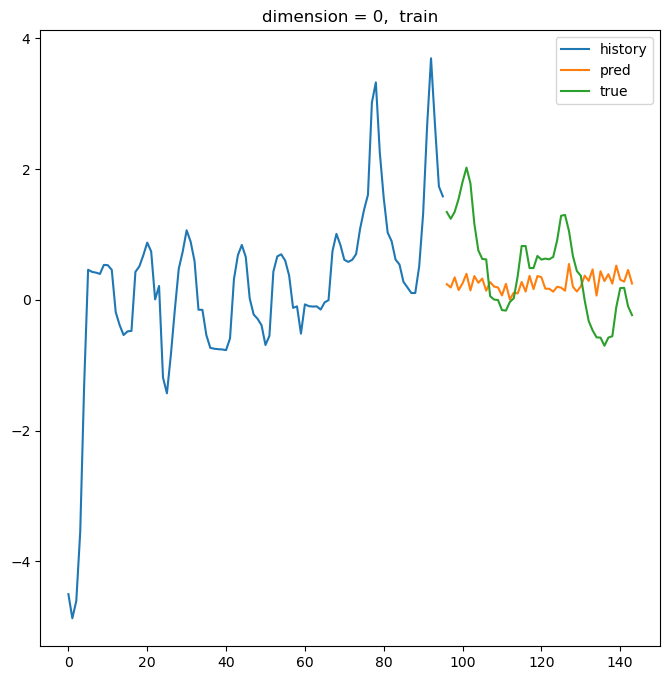

In [28]:
curr_model = "basis_former" 
basisformer_train_test = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)


## iTransformer

In [29]:
curr_model = "itransformer"  #"basis_former", "itransformer", "ns_autoformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

### Train

In [30]:
itransformer_train_test = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Use CPU
Epoch: 1 cost time: 36.63767194747925
Epoch: 1, Steps: 41 | Train Loss: 0.7350938
Validation loss decreased (inf --> 0.735094).  Saving model ...
Updating learning rate to 0.0001
test shape: (6, 24, 48, 24) (6, 24, 48, 24)
test shape: (144, 48, 24) (144, 48, 24)
mse:1.2126866579055786, mae:0.8379350900650024, mape4.928677558898926, rmse1.1012204885482788


### Test

## Nonstationary Transformer

In [31]:
curr_model = "ns_autoformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [32]:
ns_autoformer_train_test = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Use CPU
Epoch: 1 cost time: 181.5009059906006
Epoch: 1, Steps: 41 | Train Loss: 1.6456554
Validation loss decreased (inf --> 1.645655).  Saving model ...
Updating learning rate to 0.0001
test shape: (6, 24, 48, 24) (6, 24, 48, 24)
test shape: (144, 48, 24) (144, 48, 24)
mse:1.8432890176773071, mae:1.0441322326660156, mape6.022145748138428, rmse1.3576778173446655


# 3. Results - Models Performance Comparison

# 6. Outlook 

## Chronos Simulation

In [22]:
!pip install "chronos[training] @ git+https://github.com/amazon-science/chronos-forecasting.git"

In [ ]:
!python supporting_files_chronos/kernel-synth.py --num-series 500 --max-kernels 2

In [ ]:
import pyarrow.ipc as ipc

file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch = table.to_pandas()

print(df_ch)

In [ ]:
import matplotlib.pyplot as plt 

# Number of time series
num_series = 15
# Number of plots per row
plots_per_row = 5
# Number of rows
num_rows = (num_series + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 3))

for i in range(num_series):
    row = i // plots_per_row
    col = i % plots_per_row
    ax = axes[row, col]
    ax.plot(df_ch['target'].iloc[i])
    ax.set_title(f'Time Series {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

# Remove any empty subplots
for j in range(i + 1, num_rows * plots_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [ ]:
!python supporting_files_chronos/kernel-synth-mult.py --num-series 500 --max-kernels 2 --dimensions 3

In [ ]:
import pyarrow.ipc as ipc

file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch_mult = table.to_pandas()

print(df_ch_mult)

In [ ]:
print(df_ch_mult.head())
print(df_ch_mult['target'].head().apply(lambda x: np.array(x).shape))

In [ ]:
# Function to plot multivariate time series
def plot_multivariate_time_series(data, num_rows=3, num_cols=5):
    num_series = num_rows * num_cols
    time_points = np.arange(len(data[0]) // 3)  # 1024 time points for reshaped data
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axs = axs.flatten()  # Flatten to easily iterate over subplots
    
    for i in range(num_series):
        series = np.array(data[i]).reshape(-1, 3)  # Reshape to [1024, 3]
        for j in range(series.shape[1]):
            axs[i].plot(time_points, series[:, j], label=f'Dimension {j+1}')
        axs[i].set_title(f'Time Series {i+1}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Value')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Extract the 'target' column as a list and plot the first 15 multivariate time series
plot_multivariate_time_series(df_ch_mult['target'].head(15).tolist(), num_rows=3, num_cols=5)

## DYNOTEARS Causal Structure

In [ ]:
from causalnex.structure.notears import from_pandas
df_str = df.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [ ]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("supporting_files_dynotears/01_fully_connected.html")

In [ ]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

In [ ]:
from causalnex.structure.notears import from_pandas
df_str = df.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [ ]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

## Granger causality test with nonlinear forecasting methods

In [ ]:
!pip install nonlincausality

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  7 23:29:32 2022

@author: Maciej Rosoł

contact: mrosol5@gmail.com, maciej.rosol.dokt@pw.edu.pl
"""
#%%
import os

# os.chdir(os.path.dirname(__file__))
import numpy as np
##import tensorflow
import nonlincausality as nlc
import matplotlib.pyplot as plt
import copy
from nonlincausality.utils import prepare_data_for_prediction, calculate_pred_and_errors
from sklearn.svm import SVR

In [ ]:
#%% Data generation Y->X
np.random.seed(10)
y = (
    np.cos(np.linspace(0, 20, 10_100))
    + np.sin(np.linspace(0, 3, 10_100))
    - 0.2 * np.random.random(10_100)
)
np.random.seed(20)
x = 2 * y ** 3 - 5 * y ** 2 + 0.3 * y + 2 - 0.05 * np.random.random(10_100)
data = np.vstack([x[:-100], y[100:]]).T

plt.figure()
plt.plot(data[:, 0], label="X")
plt.plot(data[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

#%% Test in case of presence of the causality
lags = [50, 150]
data_train = data[:6000, :]
data_val = data[6000:8000, :]
data_test = data[8000:, :]


In [ ]:
results = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

#%% Example of obtaining the results
for lag in lags:
    best_model_X = results[lag].best_model_X
    best_model_XY = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)
    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"Test statistic = {test_statistic} p-value = {p_value}")

    # Using models for prediction
    data_X, data_XY = prepare_data_for_prediction(data_test, lag)
    X_pred_X = best_model_X.predict(data_X)
    X_pred_XY = best_model_XY.predict(data_XY)

    # Plot of true X vs X predicted
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data_test[lag:, 0], X_pred_X, "o")
    ax[0].set_xlabel("X test values")
    ax[0].set_ylabel("Predicted X values")
    ax[0].set_title("Model based on X")
    ax[1].plot(data_test[lag:, 0], X_pred_XY, "o")
    ax[1].set_xlabel("X test values")
    ax[1].set_ylabel("Predicted X values")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

    # Another way of obtaining predicted values (and errors)
    X_pred_X, X_pred_XY, error_X, error_XY = calculate_pred_and_errors(
        data_test[lag:, 0], 
        data_X, 
        data_XY, 
        best_model_X, 
        best_model_XY
    )
    # Plot of X predicted vs prediction error
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(X_pred_X, error_X, "o")
    ax[0].set_xlabel("Predicted X values")
    ax[0].set_ylabel("Prediction errors")
    ax[0].set_title("Model based on X")
    ax[1].plot(X_pred_XY, error_XY, "o")
    ax[1].set_xlabel("Predicted X values")
    ax[1].set_ylabel("Prediction errors")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

In [ ]:
#%% Test in case of absence of the causality
np.random.seed(30)
data_noise = np.vstack([x[:-100], np.random.random(10_000)]).T

lags = [50, 150]
data_noise_train = data_noise[:6000, :]
data_noise_val = data_noise[6000:8000, :]
data_noise_test = data_noise[8000:, :]

results = nlc.nonlincausalityNN(
    x=data_noise_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_noise_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.001, 0.0001],
    batch_size_num=32,
    x_val=data_noise_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

#%% Example of obtaining the results
for lag in lags:
    best_model_X_lag50 = results[lag].best_model_X
    best_model_XY_lag50 = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag].test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)

    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"test statistic = {test_statistic} p-value = {p_value}")
#%% Example of the measure of the causality change over time

data_test_measure = copy.copy(data_test)
np.random.seed(30)
data_test_measure[:1000, 1] = np.random.random(1000)

plt.figure()
plt.plot(data_test_measure[:, 0], label="X")
plt.plot(data_test_measure[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

results = nlc.nonlincausalitymeasureNN(
    x=data_train,
    maxlag=lags,
    window=100,
    step=1,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test_measure,
    run=3,
    epochs_num=[50,50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    verbose=True,
    plot=True,
)


#%% Example of usage for conditional analysis
np.random.seed(30)
z = np.random.random([10_000, 2])

z_train = z[:6000, :]
z_val = z[6000:8000, :]
z_test = z[8000:, :]

results_conditional = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=1,
    z=z_train,
    z_test=z_test,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    z_val=z_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)
# %% Exaple of the usage the package with Scikit-learn model

parametres = {
    'kernel':['poly', 'rbf'],
    'C':[0.01,0.1,1], 
    'epsilon':[0.01,0.1,1.]
}
results_skl = nlc.nonlincausality_sklearn(    
    x=data_train,
    sklearn_model=SVR,
    maxlag=lags,
    params=parametres,
    x_test=data_test,
    x_val=data_val,
    plot=True)

#%% Example of usage other functions for causality analysis

# ARIMA/ARIMAX models
results_ARIMA = nlc.nonlincausalityARIMA(x=data_train[::10], maxlag=[5,15], x_test=data_test[::10])